### Домашнее задание

1. Загрузить данные с использованием cudf\dask-cudf
2. Провести базовый анализ данных.
3. Найти в ходе выполнения п. 2 применение cuda.jit и cupy.
4. Использовать два метода снижения размерности из cuml для визуализации классов в пространстве размерности 2.
5. Обучить классическую модель и нейронку с помощью GPU\Multi-GPU.

## Настройка окружения

In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!pip uninstall cupy-cuda11x --yes
!pip install cupy-cuda12x
!pip install graphviz

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 438 (delta 121), reused 57 (delta 54), pack-reused 269
Receiving objects: 100% (438/438), 118.31 KiB | 4.55 MiB/s, done.
Resolving deltas: 100% (223/223), done.
***********************************************************************
We will now install RAPIDS via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 753.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Импорт библиотек

In [2]:
import cupy as cp
import cudf as cd
from numba import cuda

import matplotlib.pyplot as plt

from cuml.model_selection import train_test_split
from cuml.metrics import roc_auc_score

from cuml.ensemble import RandomForestClassifier
from cuml import TSNE, TruncatedSVD, KMeans

import torch
from torch.utils.data import (
    Dataset,
    DataLoader,
    DistributedSampler
)

from tqdm import tqdm
import warnings
warnings.simplefilter("ignore")

## Вспомогательные функции

In [3]:
def get_const_columns(data:cd.DataFrame) -> list:
    """
    Возвращает названия столбцов с одним уникальным значением.
    """
    return [col for col in data.columns if data[col].nunique() == 1]

def calc_filling_value(values:cd.Series, type_fill:str):
    """
    Вычисляет значение для заполнения пропусков с использованием
    ['mean', 'median', 'moda', 'min', 'max'].
    """
    if type_fill not in ("mean", "median", "moda", "min", "max"):
        raise NotImplementedError(
            "Unknown value calculation operation. The following operations are available" +
            "['mean', 'median', 'moda', 'min', 'max']."
        )

    if type_fill == "mean":
        return cp.mean(values)
    elif type_fill == "median":
        return cp.median(values)
    elif type_fill == "moda":
        return values.value_counts().index[0]
    elif type_fill == "min":
        return cp.min(values)
    else:
        return cp.max(values)

def fillna_cols(data:cd.DataFrame, filling_map:dict) -> cd.DataFrame:
    """
    Заполняет пропуски в столбцах на основе 'filling_map', в котором тип
    заполнения пропусков.
    """
    for col, type_fill in filling_map.items():
        if "const" in type_fill:
            fill_value = cd.Series([type_fill.split("=")[-1]]).astype(str(data[col].dtype))[0]
            data[col] = data[col].fillna(fill_value)
        else:
            data[col] = data[col].fillna(calc_filling_value(data[col], type_fill))

    return data

def show_reduced_data(reduced_data:cd.DataFrame, classes:cp.array, title:str="", figsize:tuple=(8, 6)) -> None:
    """
    Строит облако точек на основе данных с уменьшенным кол-вом размерностей.
    """
    plt.figure(figsize=figsize)
    if title != "": plt.title(title)
    plt.scatter(reduced_data[0].to_numpy(), reduced_data[1].to_numpy(), c=classes.to_numpy())
    plt.show()

## Работа с данными

### Загрузка данных

In [4]:
NAME_TARGET = "default_status"

raw_data = cd.read_csv("Train_Set_90621.csv").drop(columns=["Amount Defaulted"])
raw_data.columns = [col.lower().replace(" ", "_").replace("-", "_") for col in raw_data.columns]

raw_data.shape

(195118, 28)

### Анализ данных

In [5]:
# Типы данных в столбцах
raw_data.dtypes

application_id                     int64
bank_masked                       object
bank_type                         object
approved_timestamp                object
name_masked                       object
business_owner_state              object
business_industry_type_code        int64
approved_year                      int64
new_business                       int64
term                               int64
bankstate                         object
interest_rate                      int64
employees                          int64
gross_disbursed_amount             int64
term_years                         int64
jobs_retained                      int64
male_to_female_employees_ratio     int64
expected_company_income            int64
funds_available_with_company       int64
gross_apprv_amount                 int64
company_branch_code                int64
city_or_rural                      int64
jobs_generated                     int64
carry_forward_credit              object
documents_provid

In [6]:
# Анализ кол-ва пропущенных значений в %
raw_data.isna().sum() / raw_data.shape[0]

application_id                    0.000000
bank_masked                       0.000410
bank_type                         0.000410
approved_timestamp                0.002183
name_masked                       0.000005
business_owner_state              0.000015
business_industry_type_code       0.000000
approved_year                     0.000000
new_business                      0.000185
term                              0.000000
bankstate                         0.000415
interest_rate                     0.000000
employees                         0.000000
gross_disbursed_amount            0.000000
term_years                        0.000000
jobs_retained                     0.000000
male_to_female_employees_ratio    0.000000
expected_company_income           0.000015
funds_available_with_company      0.000000
gross_apprv_amount                0.000000
company_branch_code               0.000000
city_or_rural                     0.000000
jobs_generated                    0.000000
carry_forwa

In [7]:
# Кол-во уникальных значений в столбцах
raw_data.nunique()

application_id                    195118
bank_masked                        42529
bank_type                              2
approved_timestamp                  6408
name_masked                       150526
business_owner_state                  10
business_industry_type_code         2077
approved_year                         19
new_business                           3
term                                 364
bankstate                             12
interest_rate                         11
employees                            431
gross_disbursed_amount             36989
term_years                            39
jobs_retained                        234
male_to_female_employees_ratio        50
expected_company_income             1854
funds_available_with_company      186948
gross_apprv_amount                  9034
company_branch_code                 1635
city_or_rural                          3
jobs_generated                       154
carry_forward_credit                   2
documents_provid

In [8]:
# Распределение классов
raw_data.groupby(NAME_TARGET)["application_id"].count().to_dict(), raw_data[NAME_TARGET].mean()

({0: 159880, 1: 35238}, 0.18059840711774414)

In [9]:
# Средние значения признаков по классам
raw_data.groupby(NAME_TARGET).mean()

,application_id,business_industry_type_code,approved_year,new_business,term,interest_rate,employees,gross_disbursed_amount,term_years,jobs_retained,male_to_female_employees_ratio,expected_company_income,funds_available_with_company,gross_apprv_amount,company_branch_code,city_or_rural,jobs_generated,balance_left,final_appved_amount
default_status,,,,,,,,,,,,,,,,,,,
0,1.020298e+09,398862.625888,2008.108913,1.277061,118.494189,7.328434,20.561290,1.484773e+07,9.889336,10.331511,15.256367,1.850230e+07,1.254084e+06,1.431495e+07,2910.253484,0.722742,7.974781,10.945709,1.119175e+07
1,1.020298e+09,400203.059084,2008.185538,1.289473,75.557324,7.325558,12.597168,1.095613e+07,6.324110,16.349566,15.659714,1.752179e+07,1.249071e+06,1.016578e+07,2370.204524,0.899682,13.956950,1.191895,7.521862e+06


### Обработка данных

In [10]:
# Удаление константных столбцов
data = raw_data.drop(columns=get_const_columns(raw_data))

# Удаление записей с пропусками в столбцах, в которых они критичны, и записей с нулевым сроком кредита
data = data.dropna(subset=["approved_timestamp", "business_owner_state"]).query("term != 0")

# Заполнение пропусков
data = fillna_cols(
    data=data,
    filling_map={
        "bank_type": "moda",
        "documents_provided": "moda",
        "carry_forward_credit": "moda",
        "new_business": "moda",
        "bankstate": "moda",
        "bank_masked": "const=-1",
        "name_masked": "const=-1",
        "expected_company_income": "const=-1",
    }
)

# Обработка категориальных признаков
categorical_cols = [
    "bank_masked", "bank_type", "name_masked", "documents_provided",
    "business_owner_state", "bankstate", "carry_forward_credit"
]

map_categorical_cols = {}
for col in categorical_cols:
    categories, unique_orig_values = cd.factorize(data[col])
    map_categorical_cols[col] = unique_orig_values
    data[col] = categories

### Генерация признаков

Создание доп. признаков:
1. Выданная сумма с учетом процентов
2. Отношение выданной суммы к предварительно одобренной сумме
3. Отношение ожидаемых доходов компании к выданной сумме
4. Отношение остатка к выданной сумме
5. Отношение общей выплаченной суммы к выданной сумме
6. Отношение доступных в компании средств к выданной сумме
7. Размер ежемесячного платежа без учета процентов
8. Отношение средних ежемесячных доходов компании к размеру ежемесячного платежа без учета процентов
9. Отношение ожидаемых доходов компании к выданной сумме с учетом процентов
10. Месяц одобрения кредита

In [11]:
@cuda.jit
def cuda_calc_ratio(values_1, values_2, out):
    """
    Рассчитывает отношение двух значений на GPU.
    """
    tid = cuda.grid(1)
    if tid < out.size:
        out[tid] = values_1[tid] / values_2[tid]

nthreads = 256
nblocks = (data.shape[0] // nthreads) + 1

divisible_cols = [
    "final_appved_amount", "expected_company_income", "balance_left",
    "gross_disbursed_amount", "funds_available_with_company", "final_appved_amount"
]

divider_cols = [
    "gross_apprv_amount", "final_appved_amount", "final_appved_amount",
    "final_appved_amount", "final_appved_amount", "term"
]

result_cols = [
    "appved_amnt_to_gross_appved", "expected_inc_to_appved_amnt", "balance_left_to_appved_amnt",
    "gross_disb_amnt_to_appved_amnt", "funds_avail_comp_to_appved_amnt", "monthly_payment_without_prc"
]

In [12]:
# Выданная сумма с учетом процентов
data["appved_amnt_with_prc"] = round(data["final_appved_amount"] + data["final_appved_amount"] * (data["interest_rate"] / 100), 2)

## Расчет признаков отношений (признаки 2 - 7)
for divisible_col, divider_col, result_col in zip(divisible_cols, divider_cols, result_cols):
    data[result_col] = cp.zeros(data.shape[0])
    cuda_calc_ratio[nblocks, nthreads](data[divisible_col], data[divider_col], data[result_col])
    data[result_col] = data[result_col].round(4)
##

# Признаки 8 - 10
data["monthly_expected_inc_to_payment"]  = round((data["expected_company_income"] / data["term"]) / data["monthly_payment_without_prc"], 4)
data["expected_inc_to_appved_amnt_perc"] = round(data["expected_company_income"] / data["appved_amnt_with_prc"], 4)
data["month_approved"] = cd.to_datetime(data["approved_timestamp"], format="%d-%m-%Y").dt.month

### Итоговый список признаков

In [13]:
NUM_FEATURES = [
    "term", "interest_rate", "gross_disbursed_amount", "expected_company_income", "funds_available_with_company",
    "gross_apprv_amount", "balance_left", "final_appved_amount", "appved_amnt_with_prc",
    "monthly_expected_inc_to_payment", "expected_inc_to_appved_amnt_perc", "appved_amnt_to_gross_appved",
    "expected_inc_to_appved_amnt", "balance_left_to_appved_amnt", "gross_disb_amnt_to_appved_amnt",
    "funds_avail_comp_to_appved_amnt", "monthly_payment_without_prc", "month_approved"
]

CAT_FEATURES = [
    "bank_type", "documents_provided", "business_owner_state", "new_business", "city_or_rural",
    "bankstate", "carry_forward_credit", "business_industry_type_code", "company_branch_code"
]

## Визуализация с помощью уменьшения размерности

Визуализация данных после уменьшения размерности с использованием t-SNE и TruncatedSVD.

In [14]:
tsne_perplexity = 30
reduced_data_tsne = TSNE(n_neighbors=3*tsne_perplexity, n_components=2, perplexity=tsne_perplexity).fit_transform(data[NUM_FEATURES])
reduced_data_svd  = TruncatedSVD(n_components=2).fit_transform(data[NUM_FEATURES])

[W] [22:32:55.127910] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


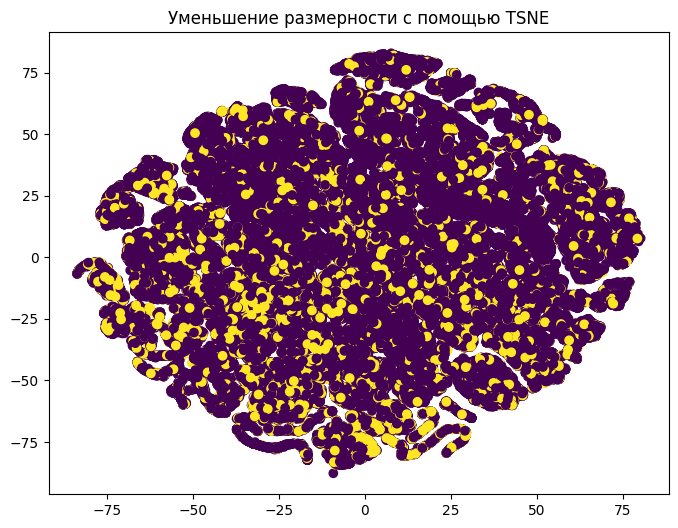

In [15]:
show_reduced_data(reduced_data_tsne, classes=data[NAME_TARGET], title="Уменьшение размерности с помощью TSNE")

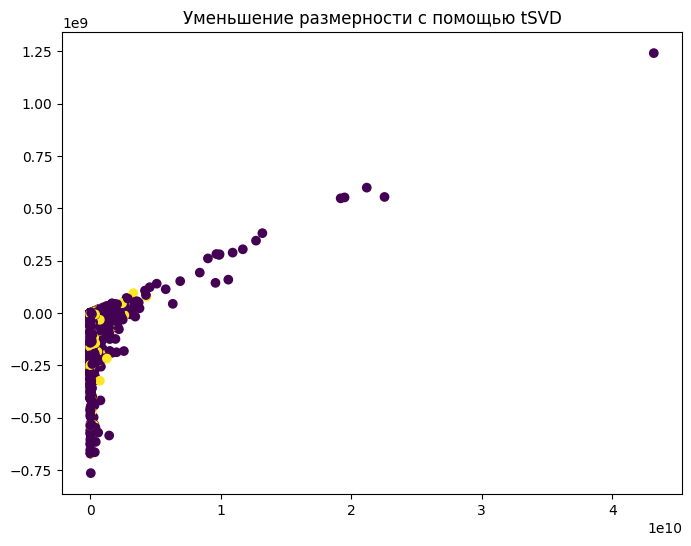

In [16]:
show_reduced_data(reduced_data_svd, classes=data[NAME_TARGET], title="Уменьшение размерности с помощью tSVD")

**Вывод**

На основе визуализации видно, что при уменьшении размерности отдельные классы не выделяются в обособленные кластера и плохо отделяются друг от друга.

## Обучение моделей

### Разбиение данных

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data[NUM_FEATURES + CAT_FEATURES], data[NAME_TARGET], random_state=42, test_size=0.25, shuffle=True
)

train_data, test_data = X_train.assign(target=y_train), X_test.assign(target=y_test)

### Обучение нейронной сети

In [18]:
class TabDataset(Dataset):
    def __init__(self, data:cd.DataFrame, features:list, target:str="target"):
        self.features, self.targets = data[features].values, data[target].values

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]).float(), torch.tensor(self.targets[idx]).float()

class NNModel(torch.nn.Module):
    def __init__(self, in_features:int, out_classes:int):
        super(NNModel, self).__init__()

        self.body = torch.nn.Sequential(
            torch.nn.BatchNorm1d(in_features),
            torch.nn.Linear(in_features, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(32),
            torch.nn.Linear(32, 8),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(8),
            torch.nn.Dropout(p=0.25),
            torch.nn.Linear(8, out_classes),
        )

    def forward(self, values):
        return self.body(values)

class TrainerModel:
    def __init__(
        self, model, learning_rate:float=0.001, n_epochs:int=16,
        device:str="cpu", dp:bool=False, threshold:float=0.5
    ):
        self.threshold = threshold
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.device = device
        self.model = model

        if self.device != "cpu":
            self.model.to(self.device)
            if dp: self.model = torch.nn.DataParallel(self.model)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    @staticmethod
    def accuracy(y_true, y_score):
        return (y_score == y_true).sum() / len(y_score)

    def run_train(self, train_loader):
        all_preds, all_facts = [], []
        self.criterion = torch.nn.BCEWithLogitsLoss()

        for epoch in range(self.n_epochs):
            self.model.train()

            for features, targets in tqdm(train_loader):
                if self.device != "cpu":
                    features, targets = features.to(self.device), targets.to(self.device).reshape(-1, 1)

                self.model.zero_grad()
                predictions = self.model(features)
                loss = self.criterion(predictions, targets)
                loss.backward()

                targets, predictions = targets.flatten(), torch.nn.functional.sigmoid(predictions).flatten()
                predictions = torch.where(predictions >= self.threshold, 1, 0)

                all_preds.extend(predictions.cpu().detach().numpy())
                all_facts.extend(targets.cpu().detach().numpy())

                self.optimizer.step()

            print(f"Epoch -> {epoch} | Accuracy = {self.accuracy(cp.array(all_preds), cp.array(all_facts))}")

        return self.model

In [19]:
BATCH_SIZE = 1024

train_loader = DataLoader(
    TabDataset(data=train_data, features=NUM_FEATURES + CAT_FEATURES),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    TabDataset(data=test_data, features=NUM_FEATURES + CAT_FEATURES),
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [23]:
DEVICE = "cuda:0"
THRESHOLD = 0.5

neural_model = TrainerModel(
    model=NNModel(in_features=len(NUM_FEATURES + CAT_FEATURES), out_classes=1),
    n_epochs=8, device=DEVICE, threshold=THRESHOLD
).run_train(train_loader)

neural_model.eval()

# Оценка модели на тестовой выборке
test_probs, test_predictions, test_targets = [], [], []
with torch.no_grad():
    for features, targets in tqdm(test_loader):
        features, targets = features.to(DEVICE), targets.to(DEVICE).reshape(-1, 1)
        predictions = neural_model(features)

        targets, probs = targets.flatten(), torch.nn.functional.sigmoid(predictions).flatten()
        classes = torch.where(predictions >= THRESHOLD, 1, 0).flatten()

        test_probs.extend(probs.cpu().detach().numpy())
        test_predictions.extend(classes.cpu().detach().numpy())
        test_targets.extend(targets.cpu().detach().numpy())

print("---")
print(f"TEST Accuracy = {TrainerModel.accuracy(cp.array(test_predictions), cp.array(test_targets))}")
print(f"TEST ROC-AUC = {roc_auc_score(cp.array(test_targets), cp.array(test_probs))}")

100%|██████████| 143/143 [00:32<00:00,  4.39it/s]


Epoch -> 0 | Accuracy = 0.51634022774171


100%|██████████| 143/143 [00:42<00:00,  3.37it/s]


Epoch -> 1 | Accuracy = 0.6639575777934694


100%|██████████| 143/143 [00:31<00:00,  4.47it/s]


Epoch -> 2 | Accuracy = 0.7214723001090034


100%|██████████| 143/143 [00:33<00:00,  4.30it/s]


Epoch -> 3 | Accuracy = 0.7510540423810732


100%|██████████| 143/143 [00:39<00:00,  3.60it/s]


Epoch -> 4 | Accuracy = 0.7691376390821776


100%|██████████| 143/143 [00:27<00:00,  5.24it/s]


Epoch -> 5 | Accuracy = 0.7813499055075286


100%|██████████| 143/143 [00:28<00:00,  4.94it/s]


Epoch -> 6 | Accuracy = 0.7902492387879761


100%|██████████| 143/143 [00:24<00:00,  5.73it/s]


Epoch -> 7 | Accuracy = 0.7970531374471265


100%|██████████| 48/48 [00:07<00:00,  6.32it/s]

---
TEST Accuracy = 0.8260458228785323
TEST ROC-AUC = 0.7854158878326416


### Обучение случайного леса

In [27]:
rf_model = RandomForestClassifier(n_estimators=1024, random_state=42).fit(X_train, y_train)
test_predictions, test_probs = rf_model.predict(X_test), rf_model.predict_proba(X_test)[1]

print(f"TEST Accuracy = {TrainerModel.accuracy(y_test, test_predictions)}")
print(f"TEST ROC-AUC = {roc_auc_score(y_test, test_probs)}")

TEST Accuracy = 0.861256221463535
TEST ROC-AUC = 0.8197924494743347


### Сравнение алгоритма кластеризации с классификаторами

In [25]:
def sigmoid(x:cp.array) -> cp.array:
    return 1 / (1 + cp.exp(-x))

alg_clustering = KMeans(n_clusters=2, max_iter=1024, random_state=42).fit(X_train[NUM_FEATURES])
test_clusters = alg_clustering.transform(X_test[NUM_FEATURES]).values

# Получение класса на основе индекса ближайшего кластера и преобразование
# расстояния до ближайшего кластера в "вероятность" с помощью sigmoid'ы
test_classes, test_probs = cp.argmin(test_clusters, axis=1), sigmoid(cp.min(test_clusters, axis=1))

print(f"TEST Accuracy = {TrainerModel.accuracy(y_test, test_classes)}")
print(f"TEST ROC-AUC = {roc_auc_score(y_test, test_probs)}")

TEST Accuracy = 0.8222615277035087
TEST ROC-AUC = 0.5
